## Configuration

### Imports

In [1]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=0.9)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

In [2]:
sns.__version__
nx.__version__

'2.5'

### Support Functions

In [3]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

LIMIT=1000000
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                    .limit(LIMIT)
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                 #.limit(LIMIT)
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

### Network analysis

#### -- Tweets

In [4]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [5]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [6]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### -- Retweets

In [7]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 1000000


,tweet_id,retweet_author
0,000001193667913368121351,000000000000004460826197
1,000001192581634291355649,000001075150211725619200
2,000001190659978471911424,000000000000000071190801


In [8]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          417
retweet_author    417
dtype: int64

In [9]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          999583
retweet_author    999583
dtype: int64

### -- Users

In [10]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 318767


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000322577469,0.16


In [11]:
len(users._id.unique())

318767

In [12]:
users.botscore.describe()

count    318767.000000
mean          0.141034
std           0.132488
min           0.000000
25%           0.040000
50%           0.100000
75%           0.200000
max           0.990000
Name: botscore, dtype: float64

0.1
0.33


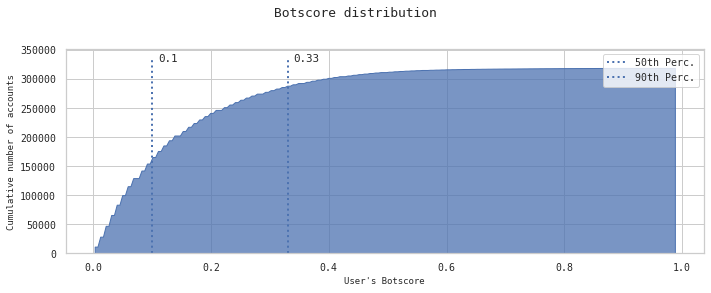

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10,4))
palette = sns.diverging_palette(133, 10, as_cmap=True)

h = sns.histplot(users.botscore, 
                 #bins=40,
                 #hist=False, 
                 #kde=True,  
                 element="poly",
                 cumulative=True,
                 palette=palette,
                 cbar=True
                )

h.set_ylabel(fontsize="small", ylabel='Cumulative number of accounts')
h.set_xlabel(fontsize="small", xlabel='User\'s Botscore')


# vertical lines for percentiles
h_ylims = h.get_ylim()
prs = [50,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

for pr,p in zip(prs,ps):
    print(p)
    label = str(pr) + "th Perc."
    h.vlines(x=p, ymin=h_ylims[0], ymax=h_ylims[1], linewidth = 2, label=label, linestyles='dotted')
    text(x=p+0.01, y=h_ylims[1], s= str(p), verticalalignment='center')
    
# common legend
h.legend(loc="upper right")

fig.suptitle("Botscore distribution", y=1.01)
plt.tight_layout()

plt.savefig("images/distribution.svg")
plt.show()

In [14]:
len(users)

318767

In [15]:
len(users[users.botscore<ps[0]])/len(users)

0.48412476824765427

In [16]:
len(users[users.botscore<=ps[0]])/len(users)

0.5193668102407087

In [17]:
len(users[users.botscore<ps[1]])/len(users)

0.8968400116699659

In [18]:
len(users[users.botscore<=ps[1]])/len(users)

0.904086684004304

### --- Build directed-weighted retweet graph

In [19]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000000000000001125213258,000000000000000022488241
1,000000000000000250738602,000000000000000022488241
2,000000000000000194176051,000000000000000022488241
3,000000000000000376943216,000000000000000022488241
4,000001121249610612260865,000000000000000022488241


In [20]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000003065,000000000000000016409683,1
1,000000000000000000003971,000000000000000142395787,1
2,000000000000000000012864,000000000000000055086343,1
3,000000000000000000012913,000000000000000198677200,1
4,000000000000000000013519,000000000000000050333404,1


In [21]:
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)

In [22]:
nx.set_node_attributes(G, values=-1, name='botscore')

node_attr = users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [23]:
#nx.write_graphml(G, "graphs/bot-infected-network.graphml")

## Graph properties

#### Ordered by botscore, analysis 50%, 90%, and 100% of the network

In [ ]:
%%time

df = pd.DataFrame()

percentile = {50: ps[0],
              90: ps[1],
              100: 1.01}

for percentage in [50, 90, 100]:
    print("Network " + str(percentage) +"%")
    print("--------------")
    
    nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get("botscore") < percentile[percentage] and data.get("botscore") >= 0
    )

    H = G.subgraph(nodes)
    
    print(nx.info(H))
    df_percentile = pd.DataFrame.from_dict({'out-degree':list(dict(H.out_degree()).values()),
                                      'in-degree':list(dict(H.in_degree()).values()),
                                      'out-strenght':list(dict(H.out_degree(weight='weight')).values()),
                                      'in-strenght':list(dict(H.in_degree(weight='weight')).values()),
                                      'eigenvector':list(dict(nx.eigenvector_centrality(H, weight='weight')).values()),
                                      'closeness':list(dict(nx.closeness_centrality(H)).values())
                                     },
                                      orient='columns')
    
    display(df_percentile.describe())
    
    df_percentile['network'] = str(percentage)+'%'
    
    if percentage == 50:
        df = df_percentile
    else:
        df = df.append(df_percentile, ignore_index=True)
    
    print()

Network 50%
--------------
Name: 
Type: DiGraph
Number of nodes: 134830
Number of edges: 461108
Average in degree:   3.4199
Average out degree:   3.4199


,out-degree,in-degree,out-strenght,in-strenght,eigenvector,closeness
count,134830.000000,134830.000000,134830.000000,134830.000000,1.348300e+05,134830.000000
mean,3.419921,3.419921,4.475799,4.475799,3.253595e-04,0.001515
std,65.137530,5.718362,108.555742,9.960257,2.703875e-03,0.001322
min,0.000000,0.000000,0.000000,0.000000,7.659962e-23,0.000000
25%,0.000000,1.000000,0.000000,1.000000,9.957950e-22,0.000007
50%,0.000000,2.000000,0.000000,2.000000,4.952409e-11,0.002105
75%,0.000000,3.000000,0.000000,4.000000,5.604257e-08,0.002700
max,5980.000000,110.000000,14189.000000,390.000000,2.101925e-01,0.004542



Network 90%
--------------
Name: 
Type: DiGraph
Number of nodes: 251407
Number of edges: 1419439
Average in degree:   5.6460
Average out degree:   5.6460


In [ ]:
df.sample(5)

In [ ]:
rows = 3
columns = 2

fig, axs = plt.subplots(rows, columns, figsize=(15,8))

row=0
column=0
for cat in ['out-degree','in-degree','out-strenght','in-strenght', 'eigenvector', 'closeness']:
    ax = axs[row][column]
    ax = sns.boxenplot(data=df,
                       x='network',
                       y=cat,
                       order=['50%','90%','100%'],
                       ax=ax,
                       showfliers=False,
                       dodge=False,
                       k_depth=6,
                       scale='linear'
                    )
    
    column=(column+1)%columns
    if column==0:
        row=row+1

### Network property per botscore

In [23]:
%%time

nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get("botscore") <= 1 and data.get("botscore") >= 0
)

H = G.subgraph(nodes)

df_all = pd.DataFrame.from_dict({'out-degree':list(dict(H.out_degree()).values()),
                                  'in-degree':list(dict(H.in_degree()).values()),
                                  'out-strenght':list(dict(H.out_degree(weight='weight')).values()),
                                  'in-strenght':list(dict(H.in_degree(weight='weight')).values()),
                                  'eigenvector':list(dict(nx.eigenvector_centrality(H, weight='weight')).values()),
                                  'closeness':list(dict(nx.closeness_centrality(H)).values()),
                                  'botscore':list(dict(H.nodes(data='botscore')).values()),
                                 },
                                  orient='columns')
df_all.head()

CPU times: user 17min 5s, sys: 2.75 s, total: 17min 8s
Wall time: 17min 8s


,out-degree,in-degree,out-strenght,in-strenght,eigenvector,closeness,botscore
0,0,1,0,1,2.338902e-32,0.000005,0.16
1,0,36,0,47,8.193768e-03,0.003931,0.17
2,0,1,0,1,6.431266e-06,0.002686,0.07
3,0,1,0,1,3.200276e-20,0.000012,0.09
4,0,2,0,2,2.923628e-31,0.000012,0.09


In [24]:
BINS=20

rows = 3
columns = 2


## balance dataset for regression
df_balanced=df_all
df_balanced['botscore']=df_balanced['botscore'].round(decimals=1)
max_size = df_balanced['botscore'].value_counts().max()
lst = [df_balanced]

for botscore, botscore_group in df_balanced.groupby('botscore'):
    print(botscore, len(botscore_group))
    lst.append(botscore_group.sample(max_size-len(botscore_group), replace=True))
    
df_balanced = pd.concat(lst, ignore_index=True).reset_index(drop=True)

0.0 56336
0.1 61186
0.2 37345
0.3 15651
0.4 9780
0.5 3586
0.6 1552
0.7 484
0.8 340
0.9 82
1.0 4


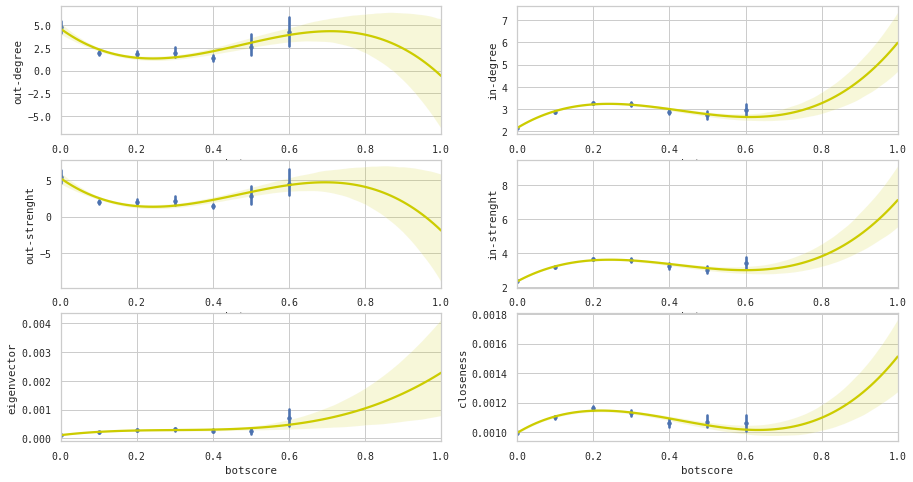

In [44]:
fig, axs = plt.subplots(rows, columns, figsize=(15,8))

row=0
column=0
for cat in ['out-degree','in-degree','out-strenght','in-strenght', 'eigenvector', 'closeness']:
    
    ax = axs[row][column]
    
    ## calculate best regression order
    
    X = df_balanced[[cat,'botscore']]
    y = X[cat]

    """x_train, x_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        stratify=X['botscore'],
                                                        test_size=0.3)
    rmses = []
    degrees = np.arange(1, 10)
    min_rmse, min_deg = 1e10, 0

    for deg in degrees:

        # Train features
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        x_poly_train = poly_features.fit_transform(x_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Compare with test data
        x_poly_test = poly_features.fit_transform(x_test)
        poly_predict = poly_reg.predict(x_poly_test)
        poly_mse = mean_squared_error(y_test, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        rmses.append(poly_rmse)

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg

    # Plot and present results
    print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))"""

    ## plot regression
    
    ax = sns.regplot(x='botscore',
            y=cat,
            x_bins=100,
            data=df_all,
            scatter_kws = {'color': 'b', 's':12},
            line_kws = {'color': '#CCCC00'},
            ax = ax,
            order=3
                    )
    
    """ins_axes = inset_axes(ax,
                width="30%",
                height="30%", loc=1)
    
    ins_axes.plot(degrees, rmses)
    ins_axes.set_yscale('log')
    ins_axes.set_xlabel('Degree', fontsize='small')
    ins_axes.set_ylabel('RMSE', fontsize='small')
    ins_axes.tick_params(labelsize=8)"""
    
    column=(column+1)%columns
    if column==0:
        row=row+1
    
    #break